In [1]:
%run -i lmu_laguerre_cell.py

# Importing libraries for LMU
from nengolib.signal import LinearSystem, Identity, cont2discrete
from nengolib.synapses import LegendreDelay
# Importing modifications for Legendre
#from lmu_laguerre_cell import *

Using TensorFlow backend.


In [7]:
import os
import sys
import pickle

with open("99_Data/X_test.pkl", 'rb') as f:
    X_test = pickle.load(f)
with open("99_Data/X_train.pkl", 'rb') as f:
    X_train = pickle.load(f)
with open("99_Data/X_valid.pkl", 'rb') as f:
    X_valid = pickle.load(f)
with open("99_Data/Y_test.pkl", 'rb') as f:
    Y_test = pickle.load(f)
with open("99_Data/Y_train.pkl", 'rb') as f:
    Y_train = pickle.load(f)
with open("99_Data/Y_valid.pkl", 'rb') as f:
    Y_valid = pickle.load(f)
    
print(f"X_test: {X_test.shape}")

X_test: (10000, 784, 1)


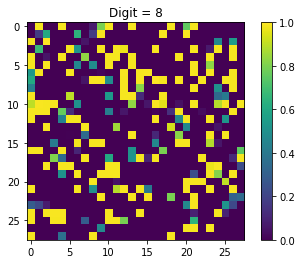

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

In [4]:
#from lmu_laguerre_cell import LMUCell, LaguerreCell

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dense
from keras.layers.recurrent import RNN
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.utils import multi_gpu_model, to_categorical

seed = 0  # to help with reproducibility

from tensorflow import set_random_seed
set_random_seed(seed=seed)
np.random.seed(seed=seed)

In [5]:
n_pixels = 785 - 1
assert n_pixels == 28**2

def laguerre_layer(**kwargs):
    return RNN(LaguerreCell(units=212,
                        order=50,
                        a = 0.95,
                        theta=n_pixels,
                        input_encoders_initializer=Constant(1),
                        hidden_encoders_initializer=Constant(0),
                        memory_encoders_initializer=Constant(0),
                        input_kernel_initializer=Constant(0),
                        hidden_kernel_initializer=Constant(0),
                        memory_kernel_initializer='glorot_normal',
                      ),
               return_sequences=False,
               **kwargs)

model = Sequential()
model.add(laguerre_layer(
    input_shape=X_train.shape[1:],  # (nr. of pixels, 1)
))
model.add(Dense(10, activation='softmax'))

# model = multi_gpu_model(model, gpus=4)

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 212)               58569     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2130      
Total params: 60,699
Trainable params: 58,149
Non-trainable params: 2,550
_________________________________________________________________


In [6]:
import time

batch_size = 100
epochs = 10
fname = os.path.abspath('models/psMNIST-laguerre.hdf5')
print(fname)

callbacks = [
    # CSVLogger('log-ctn19-pmnist-dn-090419.csv', append=True, separator=';')
    # EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5),
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

t = time.time()

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, to_categorical(Y_valid)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

/data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/models/psMNIST-laguerre.hdf5

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 323s 6ms/step - loss: 0.7811 - accuracy: 0.7520 - val_loss: 0.5630 - val_accuracy: 0.8288

Epoch 00001: val_loss improved from inf to 0.56302, saving model to /data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/models/psMNIST-laguerre.hdf5
Epoch 2/10
50000/50000 [==============================] - 320s 6ms/step - loss: 0.4793 - accuracy: 0.8490 - val_loss: 0.4258 - val_accuracy: 0.8650

Epoch 00002: val_loss improved from 0.56302 to 0.42575, saving model to /data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/models/psMNIST-laguerre.hdf5
Epoch 3/10
50000/50000 [==============================] - 320s 6ms/step - loss: 0.3702 - accuracy: 0.8836 - val_loss: 0.3581 - val_accuracy: 0.8900

Epoch 00003: val_loss improved from 0.

In [ ]:
plt.figure()
plt.plot(result.history['val_accuracy'], label="Validation")
plt.plot(result.history['accuracy'], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("psMNIST - Laguerre Cell")
plt.show()

In [ ]:
n_pixels = 785 - 1
assert n_pixels == 28**2

def LMU_layer(**kwargs):
    return RNN(LMUCell(units=212,
                       order=256,
                       theta=n_pixels,
                       input_encoders_initializer=Constant(1),
                       hidden_encoders_initializer=Constant(0),
                       memory_encoders_initializer=Constant(0),
                       input_kernel_initializer=Constant(0),
                       hidden_kernel_initializer=Constant(0),
                       memory_kernel_initializer='glorot_normal',
                      ),
               return_sequences=False,
               **kwargs)

model = Sequential()
model.add(LMU_layer(
    input_shape=X_train.shape[1:],  # (nr. of pixels, 1)
))
model.add(Dense(10, activation='softmax'))

# model = multi_gpu_model(model, gpus=4)

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
### import time

batch_size = 100
epochs = 10
fname = os.path.abspath('models/psMNIST-LMU.hdf5')
print(fname)

callbacks = [
    # CSVLogger('log-ctn19-pmnist-dn-090419.csv', append=True, separator=';')
    # EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5),
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

t = time.time()

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, to_categorical(Y_valid)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))